# BL Lac SED plot figure (version 1)
## using the lowest chi^2 to perform model fit again to plot figure


In [ ]:
# import numpy, astropy and matplotlib for basic functionalities
import numpy as np
import pkg_resources
import pandas as pd
from pathlib import Path
import os, sys
from astropy.constants import c
from astropy.coordinates import Distance
from astropy.table import Table
import astropy.units as u
import matplotlib.pyplot as plt
#%matplotlib widget

# import agnpy classes
import agnpy
from agnpy.spectra import BrokenPowerLaw
from agnpy.synchrotron import Synchrotron
from agnpy.compton import SynchrotronSelfCompton
from agnpy.utils.plot import load_mpl_rc, sed_x_label, sed_y_label, plot_sed
from agnpy.emission_regions import Blob

load_mpl_rc()

# import sherpa classes
from sherpa.models import model
from sherpa import data
from sherpa.fit import Fit
from sherpa.stats import Chi2
from sherpa.optmethods import LevMar

from AgnpySSC import AgnpySSC

def ClearData():
    data = {
        'i': [],
        'm': [],
        'j': [],
        'k': [],
        'k_e': [],
        'p1': [],
        'p2': [],
        'gamma_b': [],
        'gamma_min': [],
        'gamma_max': [],
        'B': [],
        'delta_D': [],
        'R_b': [],
        'chi_2': []
    }
    return data

def SED_Data():
    SED_data = {
        'fit_x': [],
        'fit_y': [],
        'syn_x': [],
        'syn_y': [],
        'ssc_x': [],
        'ssc_y': []
    }
    return SED_data


In [ ]:
### read in redshift information
table = pd.read_csv('/Users/87steven/Documents/ASIAA/Blazar SED progress/spectral index New 2022_10_18.csv') # # = 37671

name_table = table.Name.values
z_table = table.z.values
source_class = table.class_name.values
alpha_table = table.alphaRadK.values

classnameall = []
QSOind = []
BL_Lac_can_ind = []
BL_Lac_galaxy_dom_ind = []
BL_Lac_ind = []
Blazar_ind = []
classclassify = [Blazar_ind, BL_Lac_can_ind, BL_Lac_galaxy_dom_ind, QSOind, BL_Lac_ind]

classnameall  = [' Blazar Uncertain type', ' BL Lac Candidate', ' BL Lac-galaxy dominated', ' QSO RLoud flat radio sp.', ' BL Lac']
    
for j in range(0, 5): # 1367
    classclassify[j] = np.where( source_class == classnameall[j] )[0]
    
BL_Lac_index = np.hstack([ classclassify[1], classclassify[2], classclassify[4]])

### read in all BL Lac parameters
BL_Lac_z = z_table[BL_Lac_index]
BL_Lac_name = name_table[BL_Lac_index]
BL_Lac_alpha = alpha_table[BL_Lac_index]

for zz in range(0, 1):   # len(BL_Lac_name)
    
    df = ClearData()
    df_2 = SED_Data()
    
    #######################################################################################################
    ### define test source name and set initial setting parameters
    #######################################################################################################
    #name = 'J1256-0547'
    #name = 'J2337-5216'
    #name = 'J0854+2006' # good source
    name = BL_Lac_name[zz]
    
    file_path = '/Users/87steven/Downloads/2023_2_15 BL Lac SED fitting result/'+name+'_SED_parameters.csv'

    try:
        SED_para = pd.read_csv(file_path) 
    except OSError:
        print('i =', i ,'File not exist... Continue to next source...')
        print('===================================')
        pass
    
    i_array = SED_para.i.values
    m_array = SED_para.m.values
    j_array = SED_para.j.values
    k_array = SED_para.k.values
    chi_square_array = SED_para.chi_squ.values

    min_i_array = i_array[chi_square_array < np.ceil(min(chi_square_array))]
    min_m_array = m_array[chi_square_array < np.ceil(min(chi_square_array))]
    min_j_array = j_array[chi_square_array < np.ceil(min(chi_square_array))]
    min_k_array = k_array[chi_square_array < np.ceil(min(chi_square_array))]
    min_chi_square_array = chi_square_array[chi_square_array < np.ceil(min(chi_square_array))]

    floor_min_chi_square_array = np.floor(min_chi_square_array*100)/100.0

    unique_floor_min_chi_square_array = np.unique(floor_min_chi_square_array)

    #######################################################################################################
    ### create a folder to save SED fitting figures
    #######################################################################################################
    path1 = '/Users/87steven/Documents/ASIAA/Blazar SED progress/SED model fit figures/'+ name +' SED model fit'
    path2 = '/Users/87steven/Documents/ASIAA/Blazar SED progress/SED model fit plotting parameters/'+ name +' SED model fit'
    if not os.path.isdir(path1):
        os.mkdir( path1 )
        
    if not os.path.isdir(path2):
        os.mkdir( path2 )

    #######################################################################################################
    ### read flux data
    #######################################################################################################
    # My source
    source = pd.read_csv('/Users/87steven/Documents/ASIAA/Blazar SED code and data/source individual flux/' + name + '_flux.csv') 

    freq = source['freq'].values
    flux = source['flux'].values
    flux_err = source['flux_err'].values

    ### set flux error which is nan to 0.01
    fluxerr_nan = np.where( np.isnan(flux_err ))[0]
    flux_err[fluxerr_nan] = 0.01
    ### find flux index which is not nan
    flux_NOTnan = np.where( (~np.isnan(flux)) & (flux > 0) )[0]
    ### save new data into array
    freq = freq[flux_NOTnan]
    flux = flux[flux_NOTnan]
    flux_err = flux_err[flux_NOTnan]

    flux_err_correct = flux_err/0.434*flux
    #######################################################################################################
    ### systematic errors
    #######################################################################################################
    # array of systematic errors, will just be summed in quadrature to the statistical error

    ### define energy ranges
    nu_vhe = 2.42E25 # [Hz]
    nu_he = 2.42E22 # [Hz]
    nu_x_ray_max = 4.25E19 # [Hz]
    nu_x_ray_min = 7.25E16 # [Hz]
    vhe_gamma = freq >= nu_vhe
    he_gamma = (freq >= nu_he) * (freq  < nu_vhe)
    x_ray = (freq  >= nu_x_ray_min) * (freq  < nu_x_ray_max)
    uv_to_radio = freq  < nu_x_ray_min

    ### declare systematics
    y_err_syst = np.zeros(len(freq ))
    y_err_syst[vhe_gamma] = 0.30
    y_err_syst[he_gamma] = 0.10
    y_err_syst[x_ray] = 0.10
    y_err_syst[uv_to_radio] = 0.05
    y_err_syst = flux * y_err_syst

    ### Constrain flux range
    #index = np.where(freq <= 1.0E19)[0]

    #freq = freq[index]
    #flux = flux[index]
    #flux_err_correct = flux_err_correct[index]
    #y_err_syst = y_err_syst[index]

    # define the data1D object containing it
    sed = data.Data1D("sed", freq, flux, staterror = flux_err_correct, syserror = y_err_syst)  # , syserror = y_err_syst

    #######################################################################################################
    # test parameters
    #######################################################################################################
    break_val = np.linspace(1.0E3, 1.0E5, 100)
    min_val = np.linspace(10, 1.0E4, 100)
    max_val = np.linspace(1.0E6, 1.0E8, 100)

    B_val = np.linspace(0.01, 1, 10)
    delta_D_val = np.array([1, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100])
    #t_var_val = np.linspace(1, 24, 24)
    t_var_val = np.array([1, 5, 10, 15, 20, 24])
    k_e_val = 10**np.linspace(-5, -9, num = 5) ## new version, 8/31 updated

    #######################################################################################################
    # calculate total number of run
    #######################################################################################################
    total_num = 0

    for i in range(0, len(unique_floor_min_chi_square_array)): # len(unique_floor_min_chi_square_array)
        chi_index = np.where(floor_min_chi_square_array == unique_floor_min_chi_square_array[i])[0]

        if len(chi_index) > 10:
            ran_index = np.random.randint(0, len(chi_index), 10)
            total_num = total_num+10
        else:
            total_num = total_num+len(chi_index)

    #######################################################################################################
    # proceed model fit
    #######################################################################################################
    count = 0

    for i in range(0, len(unique_floor_min_chi_square_array)): # len(unique_floor_min_chi_square_array)
        chi_index = np.where(floor_min_chi_square_array == unique_floor_min_chi_square_array[i])[0]

        if len(chi_index) > 10:
            ran_index = np.random.randint(0, len(chi_index), 10)

            min_i_array_new = min_i_array[chi_index[ran_index]]
            min_m_array_new = min_m_array[chi_index[ran_index]]
            min_j_array_new = min_j_array[chi_index[ran_index]]
            min_k_array_new = min_k_array[chi_index[ran_index]]
            min_chi_square_array_new  = min_chi_square_array[chi_index[ran_index]]
        else:
            min_i_array_new = min_i_array[chi_index]
            min_m_array_new = min_m_array[chi_index]
            min_j_array_new = min_j_array[chi_index]
            min_k_array_new = min_k_array[chi_index]
            min_chi_square_array_new = min_chi_square_array[chi_index]

        for aa in range(0, len(min_chi_square_array_new)):   # 
            i = min_i_array_new[aa]
            m = min_m_array_new[aa]
            j = min_j_array_new[aa]
            k = min_k_array_new[aa]

            #######################################################################################################
            ### find frequency of maximum flux between 1.0E12 ~ 1.0E20
            #######################################################################################################
            index = np.where((freq > 1.0E12) & (freq <= 1.0E20))[0]

            max_flux_index = np.where(flux == max(flux[index]))[0]

            min_freq = freq[0]
            max_freq = freq[max_flux_index][0]

            #######################################################################################################
            # declare parameters
            #######################################################################################################
            agnpy_ssc = AgnpySSC()
            # initialise parameters (parameters from Table 4 and Figure 11 of Abdo 2011)
            if BL_Lac_z[zz] == 0:
                z = 0.01
            else:
                z = BL_Lac_z[zz]                 # redshift (0.0308)
                
            d_L = Distance(z = z).to("cm")      # luminosity distance [cm]
            p1 = 2.8                            # electron distribution index (2.02)
            p2 = 2.8                            # electron distribution index (3.43)
            
            if np.isnan(2*BL_Lac_alpha[zz]+1):
                p1 = 2
                p1 = 2
            elif 2*BL_Lac_alpha[zz]+1 > 5:
                p1 = 5
                p2 = 5
            else:
                p1 = 2*BL_Lac_alpha[zz]+1
                p2 = 2*BL_Lac_alpha[zz]+1
    
            log10_B = np.log10(B_val[i])     ### magnetic field strength
            gamma_b_min = np.sqrt(min_freq/(4.2E6*B_val[i]))
            gamma_b_val = np.sqrt(max_freq/(4.2E6*B_val[i]))
            log10_gamma_b = np.log10(gamma_b_val)       # lorentz break factor (5 = np.log10(1.0E5))
            log10_gamma_min = np.log10(gamma_b_min)       # minimum lorentz factor (500)
            log10_gamma_max = np.log10(gamma_b_val*100)     # maximum lorentz factor (1.0E6)
            log10_k_e = np.log10(k_e_val[m])         #  (-7.9 = np.log10(1.26E-8))
            t_var = 60*60*t_var_val[j]                   # variability timescale [sec] (86400)
            delta_D = delta_D_val[k]                          # doppler factor (free parameter) (18)
            R_b = c*t_var*delta_D/(1+z)*100       # radius [cm] ====> Doppler factor is include in here (5.2E16 )

            print('source name =' , name, ', # of run = %1.0f/%1.0f' %(count, total_num))
            print("i = ", i, ", m = ", m, ", j = ", j, ", k = ", k)

            #######################################################################################################
            ### enter parameters into model
            #######################################################################################################
            # - AGN parameters
            agnpy_ssc.z = z                 # redshift 
            agnpy_ssc.z.freeze()
            agnpy_ssc.d_L = d_L             # luminosity distance [cgs]
            agnpy_ssc.d_L.freeze()
            # - blob parameters
            agnpy_ssc.delta_D = delta_D     # doppler factor (free parameter)
            agnpy_ssc.log10_B = log10_B     # magnetic field sterength [G] (free parameter)
            agnpy_ssc.t_var = t_var         # variability timescale [sec]
            agnpy_ssc.t_var.freeze()
            # - EED
            agnpy_ssc.log10_k_e = log10_k_e # 
            agnpy_ssc.p1 = p1               # spectral index
            agnpy_ssc.p2 = p2               # spectral index
            agnpy_ssc.log10_gamma_b = log10_gamma_b       # lorentz break factor
            agnpy_ssc.log10_gamma_min = log10_gamma_min   # minimum lorentz factor
            agnpy_ssc.log10_gamma_min.freeze()
            agnpy_ssc.log10_gamma_max = log10_gamma_max   # maximum lorentz factor
            agnpy_ssc.log10_gamma_max.freeze()

            #######################################################################################################
            ### fit using the Levenberg-Marquardt optimiser
            #######################################################################################################
            fitter = Fit(sed, agnpy_ssc, stat = Chi2(), method = LevMar())
            # Set minimum and maximum frequency to proced model fit
            min_x = 1.0E8
            max_x = 1.0E29
            sed.notice(min_x, max_x)

            #######################################################################################################
            ### perform model fit
            #######################################################################################################
            result = fitter.fit()
            print("Model fit succesful??", result.succeeded)
            print('=================================================')

            #print(result.format())

            #######################################################################################################
            ### define the emission region parameters
            #######################################################################################################
            k_e = 10**agnpy_ssc.log10_k_e.val                    
            p1 = agnpy_ssc.p1.val                            
            p2 = agnpy_ssc.p2.val                            
            gamma_b = 10**agnpy_ssc.log10_gamma_b.val        
            gamma_min = 10**agnpy_ssc.log10_gamma_min.val    
            gamma_max = 10**agnpy_ssc.log10_gamma_max.val    
            B = 10**agnpy_ssc.log10_B.val                        
            delta_D = agnpy_ssc.delta_D.val                  
            R_b = ( c.value*t_var*agnpy_ssc.delta_D/(1+agnpy_ssc.z) ).val*100    

            parameters = {
                "p1": p1,
                "p2": p2,
                "gamma_b": gamma_b,
                "gamma_min": gamma_min,
                "gamma_max": gamma_max,
            }

            spectrum_dict = {"type": "BrokenPowerLaw", "parameters": parameters}

            blob = Blob(R_b*u.cm, z, delta_D, delta_D, B*u.G, k_e*u.cm**-3, spectrum_dict, spectrum_norm_type = "differential")
            #print('=================================================')
            #print("Emission Parameters")
            #print('=================================================')
            #print(blob)
            #print(f"jet power in particles: {blob.P_jet_e:.2e}")
            #print(f"jet power in B: {blob.P_jet_B:.2e}")

            #######################################################################################################
            ### insert parameters into model and do model fit
            #######################################################################################################
            # define the radiative processes
            synch = Synchrotron(blob)
            ssc = SynchrotronSelfCompton(blob)
            # make a finer grid to compute the SED
            nu = np.logspace(8, 30, 200) * u.Hz
            synch_sed = synch.sed_flux(nu)
            ssc_sed = ssc.sed_flux(nu)

            #######################################################################################################
            ### Model fit data arrange and plot figure
            #######################################################################################################
            # put fitted parameters into array
            data_x = sed.x
            data_y = sed.y
            y_err_lin = sed.get_error()
            # use for test source Mrk 421
            #data_y_err = 0.434*y_err_lin/data_y  # relative error in log scale
            # use for other sources
            data_y_err = y_err_lin

            fit_x = np.logspace(np.log10(min_x), np.log10(max_x), 200)
            fit_y = agnpy_ssc(fit_x).to_value()

            # decomposed parameters into array
            x = ( nu/(1+z) ).value
            syn_y = synch_sed.value
            ssc_y = ssc_sed.value

            plt.rcParams['figure.figsize'] = [6, 4.5]
            plt.rcParams['axes.linewidth'] = 3

            fig, ax = plt.subplots()

            # plot data point
            ax.errorbar(np.log10(data_x), data_y, marker = ".", color = "black", ecolor = "black", linestyle = '') 
            # plot model fit line
            ax.plot(np.log10(fit_x), fit_y, '-', color = 'red')
            #ax.plot(np.log10(fit_x), np.log10(fit_y), '-', color = color[i], label = 'Total SED')

            # plot emission region
            ax.plot(np.log10(x), syn_y + ssc_y, '--', color = 'orange', label = 'Synchrotron+SSC')
            ax.plot(np.log10(x), syn_y, '--', color = 'blue', alpha = 0.5, label = 'Synchrotron')
            ax.plot(np.log10(x), ssc_y, '--', color = 'green', alpha = 0.5, label = 'SSC')

            ax.set_xlim (7, 29)
            ax.set_ylim (min(data_y)*1.0E-2, max(data_y)*1.0E2) 
            plt.yscale('log')

            plt.legend(loc = 'upper left', shadow = True, fontsize = 8, markerscale = 1) 

            plt.xlabel( "log($\\nu$) [Hz]",  fontsize = 12)
            plt.xticks(fontsize = 8)
            plt.ylabel('$\\nu$ F($\\nu$) [erg $\mathrm{cm^{-2}\ s^{-1}}$]',  fontsize = 10)
            plt.yticks(fontsize = 8)
            plt.grid(True)
            figurename = 'J1104-3812 SED Fitting ($\\chi^2$ = %4.2E)' %(float(result.rstat))
            plt.title(figurename, fontsize = 16)

            plotname = '/Users/87steven/Documents/ASIAA/Blazar SED progress/SED model fit figures/'+ name +' SED model fit/SED of '+ name + '_' + str(count)
            #fig.savefig(plotname, dpi = 300, bbox_inches = 'tight')

            count = count+1
            
            ### save figure parameters
            for ii in range(0, len(fit_x)):
                df_2['fit_x'].append(fit_x[ii])
                df_2['fit_y'].append(fit_y[ii])
                df_2['syn_x'].append(x[ii])
                df_2['syn_y'].append(syn_y[ii])
                df_2['ssc_x'].append(x[ii])
                df_2['ssc_y'].append(ssc_y[ii])
            
            CSVfile = f'/Users/87steven/Documents/ASIAA/Blazar SED progress/SED model fit plotting parameters/'+ name +' SED model fit/' + name + '_' + str(count) +'.csv'                       
            dff = pd.DataFrame(df_2)     
            dff.to_csv(CSVfile, index = False) 
            
            ### plot model fit parameters
            df['p1'].append(p1)
            df['p2'].append(p2)
            df['k_e'].append(k_e)
            df['gamma_b'].append(gamma_b) 
            df['gamma_min'].append(gamma_min)
            df['gamma_max'].append(gamma_max) 
            df['B'].append(B)
            df['delta_D'].append(delta_D)
            df['R_b'].append(R_b) 
            df['chi_2'].append(min_chi_square_array_new[aa])
        
    # CSVfile = f'/Users/87steven/Documents/ASIAA/Blazar SED progress/SED model fit parameters/'+name+'_SED_parameters.csv'                       
    # dff = pd.DataFrame(df)     
    # dff.to_csv(CSVfile, index = False) 
            
    print('==========' + name +" SED model fit figure produce complete ==========")
    

Text(0.5, 1.0, 'J1104-3812 SED Fitting ($\\chi^2$ = 1.38E+01)')

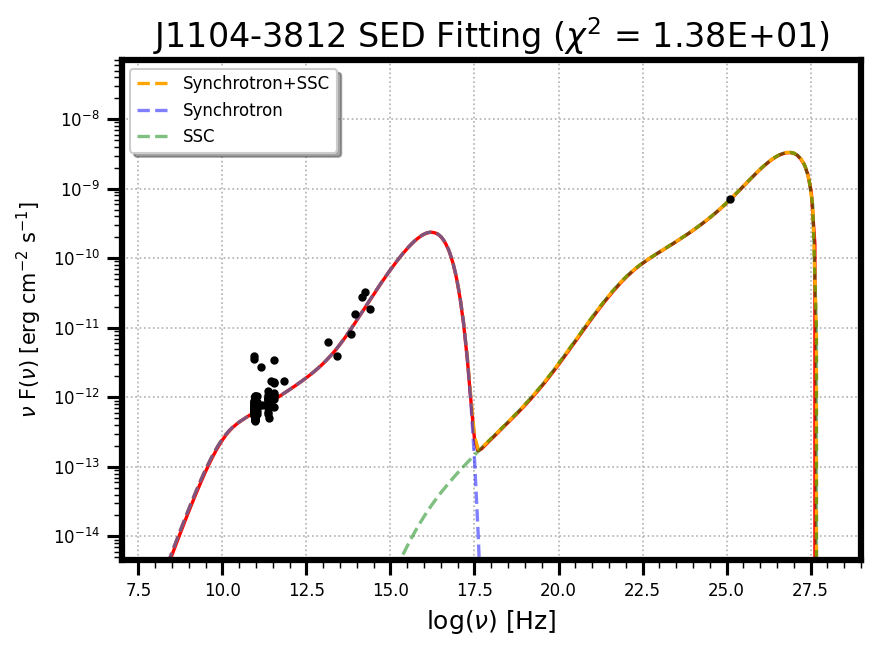

In [31]:
plt.rcParams['figure.figsize'] = [6, 4.5]
plt.rcParams['axes.linewidth'] = 3

fig, ax = plt.subplots()

### plot data point
ax.errorbar(np.log10(data_x), data_y, marker = ".", color = "black", ecolor = "black", linestyle = '') 
### plot model fit line
ax.plot(np.log10(fit_x), fit_y, '-', color = 'red')
#ax.plot(np.log10(fit_x), np.log10(fit_y), '-', color = color[i], label = 'Total SED')

### plot emission region
ax.plot(np.log10(x), syn_y + ssc_y, '--', color = 'orange', label = 'Synchrotron+SSC')
ax.plot(np.log10(x), syn_y, '--', color = 'blue', alpha = 0.5, label = 'Synchrotron')
ax.plot(np.log10(x), ssc_y, '--', color = 'green', alpha = 0.5, label = 'SSC')

ax.set_xlim (7, 29)
ax.set_ylim (min(data_y)*1.0E-2, max(data_y)*1.0E2) 
plt.yscale('log')

plt.legend(loc = 'upper left', shadow = True, fontsize = 8, markerscale = 1) 

plt.xlabel( "log($\\nu$) [Hz]",  fontsize = 12)
plt.xticks(fontsize = 8)
plt.ylabel('$\\nu$ F($\\nu$) [erg $\mathrm{cm^{-2}\ s^{-1}}$]',  fontsize = 10)
plt.yticks(fontsize = 8)
plt.grid(True)
figurename = 'J1104-3812 SED Fitting ($\\chi^2$ = %4.2E)' %(float(result.rstat))
plt.title(figurename, fontsize = 16)

